In [1]:
from __future__ import print_function
from ipywidgets import interact, interact_manual, interactive, fixed, interact_manual
from ipywidgets import Layout
import ipywidgets as widgets

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects, label

import cv2

## Tools

In [3]:
def clip(x): 
    '''
    Clip maximum to 4 sigma
    '''
    return np.clip(x, a_min=0, a_max=6*np.std(x))

In [4]:
def norm(x): 
    x = clip(x)
    return (x) / ( np.max(x)) # clip at 6-sigma ?

In [5]:
def binary_mask(x, treshold=None, sigmas = 2):
    if treshold:
        return norm(x) > treshold
    else:
        return norm(x) > sigmas*np.std(norm(x))

# Analysis

In [6]:
img = cv2.imread('img/Simono/2017-10-24 NIH FBS plius .click-it dapi 3.tif')

In [7]:
# Clip everything at 4 sigma and normalize

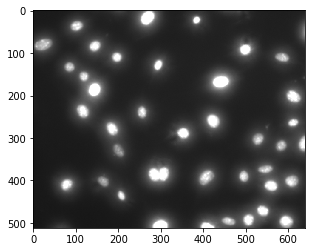

In [8]:
plt.imshow(norm(img))

In [9]:
nucleus = np.asarray(img[:,:,0], dtype=np.float32)
# cell    = np.asarray(img[:,:,1], dtype=np.float32)

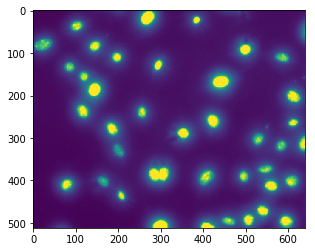

In [10]:
plt.imshow(nucleus)

In [11]:
clean_nucleus_bw = remove_small_objects(binary_mask(nucleus), min_size=32)


In [12]:
# plt.figure(figsize = (10,10))
# plt.imshow(
#     clean_nucleus_bw
# )
# # plt.colorbar()

## Adjust size treshold for cells

In [22]:
def adjust_size_treshold(cell, nucleus, min_size, binary_treshold):
    plt.figure(figsize = (17,17))
    clean_cell_bw = remove_small_objects(
                        binary_mask(cell, binary_treshold),
                        min_size=min_size
                    )
    
    clean_nucleus_bw = remove_small_objects(binary_mask(nucleus), min_size=32)

    
    # count cells
    labeled = label(clean_cell_bw, background=0)
    
    
    # display cells
    rgb = np.zeros(list(cell.shape)+[3], dtype = np.uint8)
    
    
    rgb[:,:, 1] =  cell
    
    # color binary mask region
    rgb[:,:, 0] =  clean_cell_bw*cell 
    rgb[:,:, 2] =  clean_nucleus_bw*nucleus*clean_cell_bw
    
    
    
    plt.subplot(1,2,1)
    plt.title('Original image, \n superimposed segmentation mask with cell overlapping nuclei ')
    plt.imshow(rgb)
    
    plt.subplot(1,2,2)
    plt.title('Cells Count: '+ str(np.max(labeled)))
    
    # count the number of cells
    N = np.max(labeled)
    
    plt.imshow(labeled, cmap='nipy_spectral')
    
    return N
    
    # plt.colorbar()

In [23]:
interact_manual(lambda min_size, binary_treshold: adjust_size_treshold(nucleus, nucleus*0, min_size, binary_treshold), 
         min_size=widgets.IntSlider(min=0,max=400,step=16,value=16,
                                    layout=Layout(width='600px', height='30px')
                                   ),
         binary_treshold = widgets.FloatSlider(min=0,max=1,step=0.01,value=0.43, 
                                               layout=Layout(width='600px', height='30px')),
        );

interactive(children=(IntSlider(value=16, description='min_size', layout=Layout(height='30px', width='600px'),…

# Count in all images

In [19]:
from glob import glob
from tqdm import tqdm
import os

In [20]:
paths = glob('img/Simono/*.tif')

In [21]:
cell_counts = {}

In [22]:
try:
    os.mkdir('./results')
except: pass

  0%|                                                                           | 0/5 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
100%|███████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.21it/s]


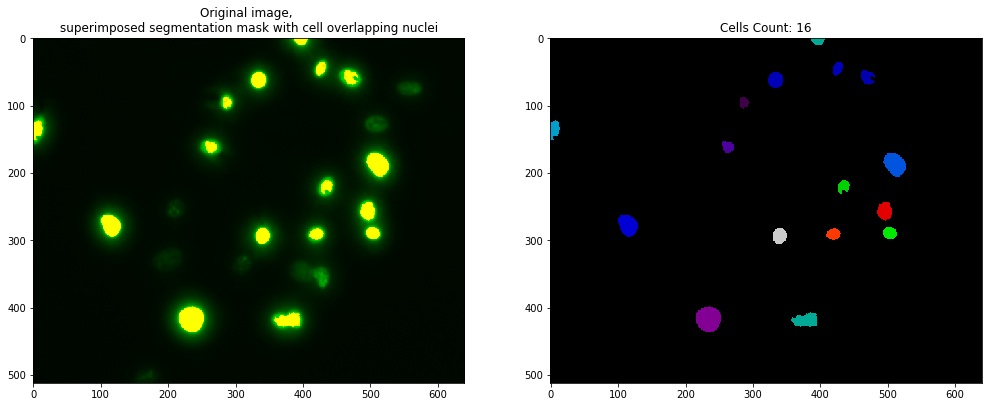

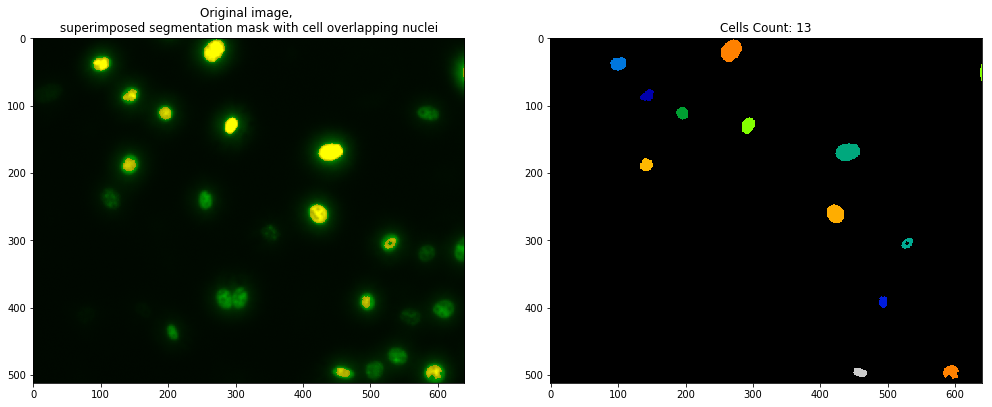

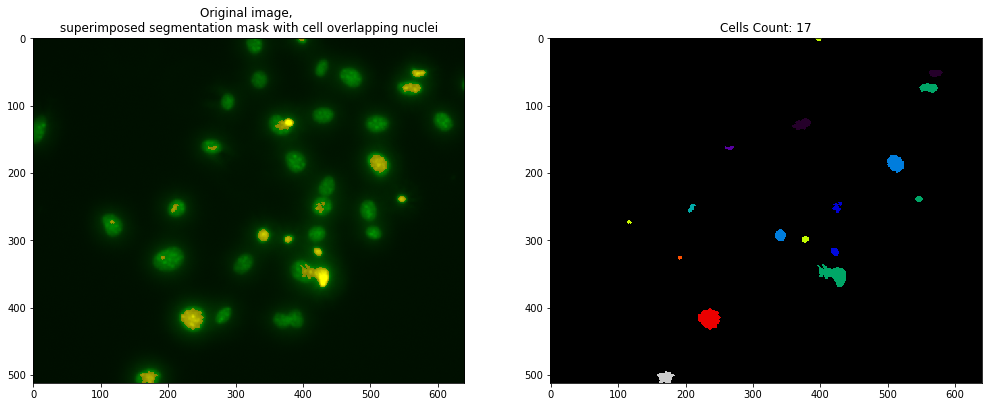

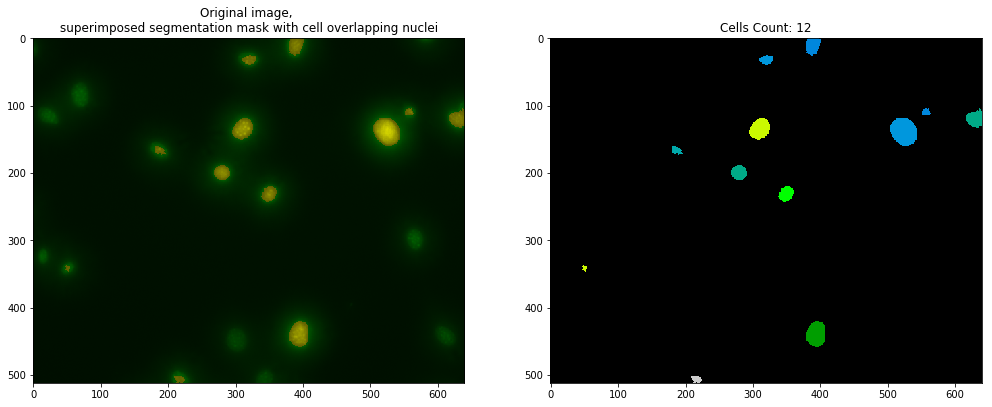

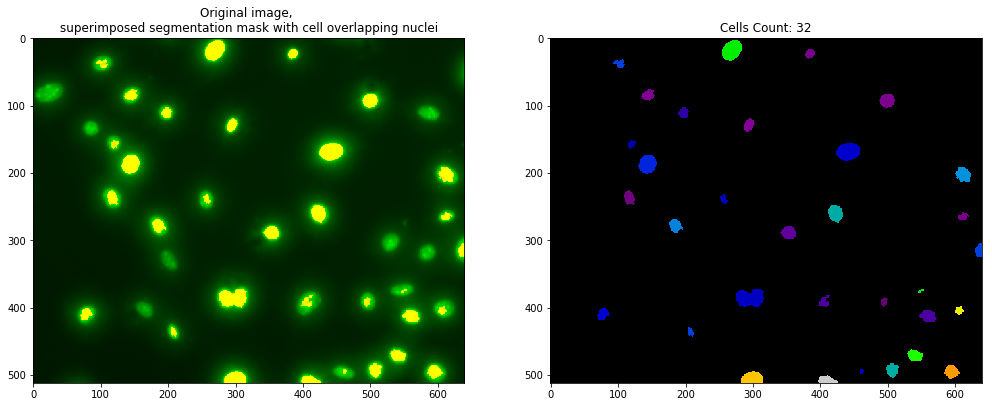

In [23]:
for path in tqdm(paths):
    # read img 
    img = cv2.imread(path)
    nucleus = np.asarray(img[:,:,0], dtype=np.float32)
    cell    = np.asarray(img[:,:,1], dtype=np.float32)
    
    name = os.path.basename(path)
    
    min_size = 32
    binary_treshold = 0.88
    
    
    cell_counts[name] = adjust_size_treshold(nucleus, nucleus*0, min_size, binary_treshold)
    plt.savefig(os.path.join('./results', name))
    

# Save XLS

In [24]:
import pandas as pd

In [25]:
df = pd.DataFrame(list(cell_counts.items()), columns=['img_name', 'cell count'])

In [26]:
df

,img_name,cell count
0,2017-10-24 NIH FBS plius .click-it green 1.tif,16
1,2017-10-24 NIH FBS plius .click-it green 3.tif,13
2,2017-10-24 NIH FBS plius .click-it dapi 1.tif,17
3,2017-10-24 NIH FBS plius .click-it dapi 2.tif,12
4,2017-10-24 NIH FBS plius .click-it dapi 3.tif,32


In [27]:
df.to_csv('results.csv')

In [28]:
df.to_excel('results.xls')